# Práctica 3 - Contraste de hipótesis

# Problema - Hagámosle competencia a Amason Prime ###

En este ejercicio vamos a tratar de introducirnos en el lucrativo mercado de los números primos. Como dominamos las mates, hemos decidido que reduciremos costes vendiendo una proporción de números que no son primos pero que lo parecen, los llamados números de Carmichael, entre cuyas hazañas destaca la de engañar al mismísimo Pierre de Fermat. El fichero `carmichael.csv` refleja los resultados de una encuesta de satisfacción realizada a los consumidores en función de si el número mandado es un verdadero primo, un número claramente compuesto o un número de Carmichael.

Propón un plan para determinar si los números de Carmichael están resultando aceptables para los consumidores y lleva a cabo el análisis correspondiente. Defiende los resultados y la conveniencia o no de vender números de Carmichael.

In [ ]:
# Importamos las librerías
import io
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

## Carga y limpieza de datos

In [6]:
# Cargamos el csv de carmichael
from google.colab import files

uploaded = files.upload()

Saving carmichael.csv to carmichael (1).csv


In [7]:
# Cargamos los datos
path = io.BytesIO(uploaded['carmichael.csv'])
df = pd.read_csv(path, index_col = 'ID')
df

,number_type,score
ID,,
1,Prime,7
2,Carmichael,10
3,Carmichael,10
4,Carmichael,1
5,Composite,1
...,...,...
2996,Composite,2
2997,Prime,7
2998,Composite,0


Comprobamos que no hayan valores sucios:

In [ ]:
print(df.number_type.unique())
print(df.score.unique())

['Prime' 'Carmichael' 'Composite']
[ 7 10  1  0  9  8  4  6  2  5  3 -1 -3 -2 -4 -5 -6]


Necesitamos limpiar las puntuaciones negativas, ya que se tratan de un error. Así que nos quedamos con los registros donde la puntuación sea mayor o igual a zero:

In [ ]:
df = df[df.score >= 0]

## Primeros análisis
Primero vamos a ver cuál es la media de satisfacción para cada tipo de número:

In [ ]:
df.groupby(by="number_type", as_index=False).mean().sort_values(by="score", ascending=False)

,number_type,score
2,Prime,8.573947
0,Carmichael,7.558522
1,Composite,4.604550


Parece que los números primos tienen más éxito, pero esta información es incompleta sin saber cuantas números de cada tipo se han mandado. Podemos ver ambas informaciones usando el método `agg` tras el `groupby`:

In [ ]:
df.groupby(by = "number_type", as_index=False).agg({"score": ["mean", "count"]}).sort_values(by = ("score", "mean"), ascending=False)

number_type     score      
                   mean count
2       Prime  8.573947  1021
0  Carmichael  7.558522   974
1   Composite  4.604550   923

Como los tamaños muestrales de cada grupo son bastante parecidos, una primera aproximación bastante razonable es que el los números primos son mejores que el resto. Ploteemos las distribuciones:

In [ ]:
h4, b4 = np.histogram(df[df.number_type == "Prime"].score, bins = np.arange(11))
h5, b5 = np.histogram(df[df.number_type == "Carmichael"].score, bins = np.arange(11))
h6, b6 = np.histogram(df[df.number_type == "Composite"].score, bins = np.arange(11))

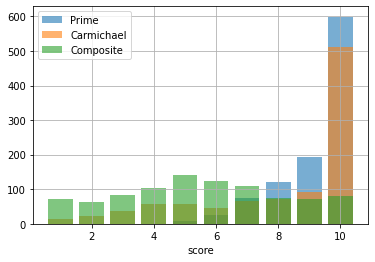

In [ ]:
import matplotlib.pyplot as plt

plt.bar(b4[1:], h4, width = 0.8, alpha = 0.6, label = "Prime")
plt.bar(b5[1:], h5, width = 0.8, alpha = 0.6, label = "Carmichael")
plt.bar(b6[1:], h6, width = 0.8, alpha = 0.6, label = "Composite")
plt.grid()
plt.legend(loc="best")
plt.xlabel('score')
plt.show()

Ploteemos también el diagrama de cajas:

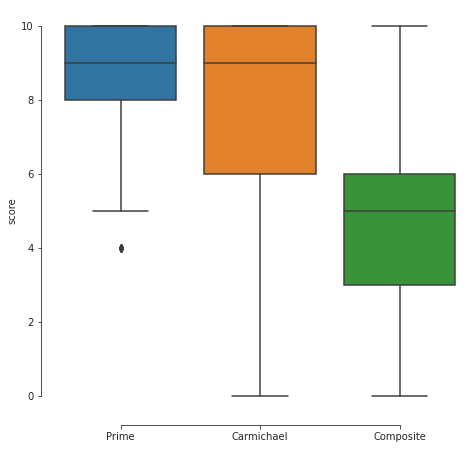

In [ ]:
plt.figure(figsize = [7.5, 7.5])
with sns.axes_style(style = 'ticks'):
    sns.boxplot(x = "number_type", y = "score", data = df)
    sns.despine(offset = 10, trim = True)
    plt.xlabel('')
    plt.ylabel('score')

Y el pair-plot:

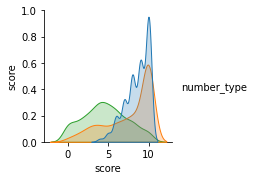

In [ ]:
sns.pairplot(data=df, hue='number_type')

## Varianzas
Vemos que las varianzas parecen distintas, vamos a calcularlas:

In [ ]:
df.groupby(by = "number_type", as_index = False).std().sort_values(by = "score", ascending=False)

,number_type,score
0,Carmichael,2.880306
1,Composite,2.689390
2,Prime,1.451729


De entrada, parece que tenemos tres muestras con distintas varianzas. Comprobémoslo con un test de **Bartlett**:

In [ ]:
print(scipy.stats.bartlett(df[df.number_type == "Prime"].score, df[df.number_type == "Carmichael"].score, df[df.number_type == "Composite"].score))

BartlettResult(statistic=477.70633188006855, pvalue=1.8509217002008444e-104)


El p-valor es muy pequeño, por lo que rechazamos la hipótesis de que los tres tipos de números tienen varianzas iguales. Vamos a probar que pasa si los comparamos dos a dos con un test de **Fisher**, que es más potente:

In [ ]:
from scipy.stats import f

F = df[df.number_type == "Prime"].score.var() / df[df.number_type == "Carmichael"].score.var()
l1, l2 = len(df[df.number_type == "Prime"]) - 1, len(df[df.number_type == "Carmichael"].score) - 1
p_value = f.cdf(F, l1, l2)
print(np.min([p_value, 1. - p_value]))

F = df[df.number_type == "Prime"].score.var() / df[df.number_type == "Composite"].score.var()
l1, l2 = len(df[df.number_type == "Prime"]) - 1, len(df[df.number_type == "Composite"].score) - 1
p_value = f.cdf(F, l1, l2)
print(np.min([p_value, 1. - p_value]))

F = df[df.number_type == "Carmichael"].score.var() / df[df.number_type == "Composite"].score.var()
l1, l2 = len(df[df.number_type == "Carmichael"]) - 1, len(df[df.number_type == "Composite"].score) - 1
p_value = f.cdf(F, l1, l2)
print(np.min([p_value, 1. - p_value]))

8.72903682235985e-98
3.4608817339791355e-79
0.017557650700751104


Los p-valores siguen siendo menores a 0.05, por lo que seguimos rechazando la hipótesis de que tienen varianzas iguales con un 95% de confianza. 

## Tests no paramétricos

Al tener varianzas distintas, no podemos usar ni un t-test o test de proporciones, vamos a realizar un test **U de Mann-Whitney** para ver si la puntuación de los números primos y los de Carmichael provienen de una distribución distinta:

In [ ]:
from scipy.stats import mannwhitneyu

print(mannwhitneyu(df[df.number_type == "Prime"].score, df[df.number_type == "Carmichael"].score))
print(mannwhitneyu(df[df.number_type == "Prime"].score, df[df.number_type == "Composite"].score))
print(mannwhitneyu(df[df.number_type == "Carmichael"].score, df[df.number_type == "Composite"].score))

MannwhitneyuResult(statistic=447636.0, pvalue=3.195056980721505e-05)
MannwhitneyuResult(statistic=102845.0, pvalue=6.10605470026851e-199)
MannwhitneyuResult(statistic=203109.5, pvalue=5.465191968099774e-97)


El test U de Mann-Whitney nos indica diferencia. Sin embargo, este es un test no-paramétrico, tan solo nos dice que los datos provienen de distribuciones distintas. Hemos de ser nosotros quienes decidamos qué las distingue.

En este caso, tratándose de distribuciones muy apuntadas y con distintas varianzas, lo más seguro es comparar las medianas:

In [ ]:
print(df[df.number_type == "Prime"].score.median())
print(df[df.number_type == "Carmichael"].score.median())
print(df[df.number_type == "Composite"].score.median())

9.0
9.0
5.0


Los datos indican que un 50% de los encuestados dan una puntuación de 5 o inferior a los números compuestos, por lo que decidimos descartarlos directamente. También nos indican que un 50% de los encuestados dan una puntuación de 9 o superior a los dos tipos de números restantes. 

Nos gustaría realizar un test para ver si estas medianas son distintas. Vamos a medir antes la curtosis de nuestras distribuciones:

In [ ]:
from scipy.stats import kurtosis

k_prime = kurtosis(df[df.number_type == "Prime"].score, fisher = False)
k_carmichael = kurtosis(df[df.number_type == "Carmichael"].score, fisher = False)
k_composite = kurtosis(df[df.number_type == "Composite"].score, fisher = False)

print(k_prime - 3)
print(k_carmichael - 3)
print(k_composite - 3)

-0.0050852070459597165
-0.3838546202820865
-0.7352695080935776


Como las curtosis son ligeramente menores a zero, significa que nuestras distribuciones son ligeramente más aplanadas que una distribución normal. Por lo que la medida de centralización de nuestras distribuciones será la mediana.  En este caso, podemos realizar un test de **Kruskal-Wallis** para ver si son significativamente distintas:

In [ ]:
from scipy import stats

print(stats.kruskal(df[df.number_type == "Prime"].score, df[df.number_type == "Carmichael"].score))
print(stats.kruskal(df[df.number_type == "Prime"].score, df[df.number_type == "Composite"].score))
print(stats.kruskal(df[df.number_type == "Carmichael"].score, df[df.number_type == "Composite"].score))

KruskalResult(statistic=15.983698480667362, pvalue=6.389026121984157e-05)
KruskalResult(statistic=904.1656671029533, pvalue=1.2197113792219422e-198)
KruskalResult(statistic=435.38779892476293, pvalue=1.092070884514664e-96)


Los p-valores son pequeños, por lo que seguimos rechazando la hipótesis de que los datos provienen de una misma distribución.

## Conclusión

Hemos visto que la distribución de puntuación de los números compuestos es distinta y con una media y mediana muy inferior, por lo que decidimos descartarlos de forma automática.

También hemos visto que aunque los números primos y los números de Carmichael puntúan similar, la puntuación de estos últimos tiene mayor dispersión. Esto se interpreta como que hay menos consenso entre los encuestados sobre el valor de dicho parámetro. O, dicho de otra manera, los números primos son más robustos a nivel de puntuaciones. 

Habría que valorar en función del coste de generar números primos o Carmichael, si nos sale a cuenta enviarlos o no, ya que hemos visto que las puntuaciones se distribuyen de distinta manera, lo que podría provocar cierto descontento en la clientela.